今週はKepler問題の数値計算を行います：

$\displaystyle \frac{\mathrm d}{\mathrm dt} q_1 = p_1, \quad \frac{\mathrm d}{\mathrm dt} q_2 = p_2, \quad
\frac{\mathrm d}{\mathrm dt} p_1 = -\frac{q_1}{(q_1^2 + q_2)^{3/2}}, \quad \frac{\mathrm d}{\mathrm dt} p_1 = -\frac{q_2}{(q_1^2 + q_2)^{3/2}}$

In [1]:
using Plots, NLsolve

In [2]:
T = 10.0;
N = 500; 
h = T / N;
t = 0:h:T;
y0 = [0.4, 0, 0, 2]

4-element Vector{Float64}:
 0.4
 0.0
 0.0
 2.0

右辺の関数を定義します．

In [3]:
function f(y) # y = [q_1, q_2 , p_1, p_2]
    return [y[3], y[4], - y[1]/ (y[1]^2+y[2]^2)^(3/2), - y[2]/ (y[1]^2+y[2]^2)^(3/2)]
end

f (generic function with 1 method)

symplectic Euler法とStörmer-Verlet法用に，$f$の下半分だけ別に定義しておきます．

In [4]:
function g(q) # q = [q_1, q_2]
    return [- q[1]/ (q[1]^2+q[2]^2)^(3/2), - q[2]/ (q[1]^2+q[2]^2)^(3/2)]
end

g (generic function with 1 method)

In [5]:
# 数値解を格納する配列
ysE = zeros(4, N+1); # symplectic Euler用
ysE[:, 1] = y0; # 初期値
ySV = zeros(4, N+1); # Störmer-Verlet用
ySV[:, 1] = y0; # 初期値
yIE = zeros(4, N+1); # 陰的Euler用
yIE[:, 1] = y0; # 初期値
yIM = zeros(4, N+1); # 陰的中点則用
yIM[:, 1] = y0; # 初期値

NLsolveを使うために

In [6]:
function nls(func, params...; ini = [0.0])
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

nls (generic function with 1 method)

f(x,params)=0 という連立非線形方程式を解きたい場合，nls(f, params, init = xの初期ベクトル) と書けばよい

### Symplectic Euler法

In [7]:
function SymEuler(y,h)
    q_next = y[1:2] + h * y[3:4]
    p_next = y[3:4] + h * g(q_next)
    return [q_next; p_next]
end

SymEuler (generic function with 1 method)

### Störmer-Verlet法

In [8]:
function StörmerVerlet(y,h)
    # （必ずしも2行とは限りません）
    #
    return [q_next; p_next]
end

StörmerVerlet (generic function with 1 method)

### 陰的Euler法

In [9]:
function ImEuler_func(y_next,y,h)
    return y_next - y - h * f(y_next)
end

function ImEuler(y,h)
    y_next = nls(ImEuler_func, y, h, ini = y)
    return y_next[1]
end

ImEuler (generic function with 1 method)

### 陰的中点則

In [10]:
function ImMidpoint_func(y_next,y,h)
    return # ここを書く
end

function ImMidpoint(y,h)
    y_next = nls(ImMidpoint_func, y, h, ini = y)
    return y_next[1]
end

ImMidpoint (generic function with 1 method)

In [11]:
for n = 1 : N
    ysE[:, n+1] = SymEuler(ysE[:, n],h) 
    # ySV[:, n+1] = StörmerVerlet(ySV[:, n],h) 
    yIE[:, n+1] = ImEuler(yIE[:, n],h) 
    # yIM[:, n+1] = ImMidpoint(yIM[:, n],h) 
end

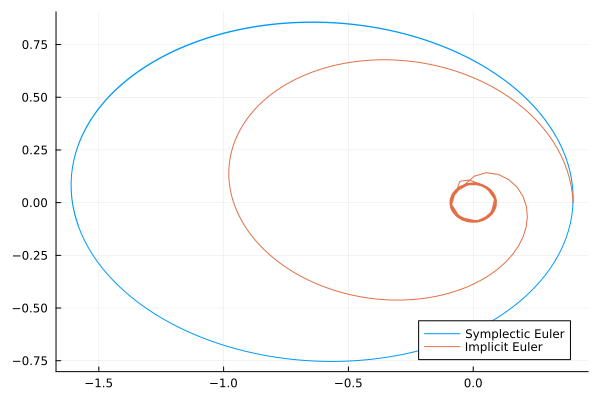

In [12]:
plot(ysE[1,:],ysE[2,:],label="Symplectic Euler")
# plot!(ySV[1,:],ySV[2,:],label="Störmer-Verlet")
plot!(yIE[1,:],yIE[2,:],label="Implicit Euler")
# plot!(yIM[1,:],yIM[2,:],label="Implicit Midpoint")

## エネルギーと角運動量の計算

In [13]:
H(y) = 1/2 * (y[3]^2 + y[4]^2) - 1/sqrt(y[1]^2 + y[2]^2)
L(y) = y[1]*y[4] - y[2]*y[3]

L (generic function with 1 method)

In [14]:
# 初期値における値
H_exact = H(y0)
L_exact = L(y0)

0.8

In [15]:
# エネルギーと角運動量の誤差を格納する配列（1行目がエネルギーで2行目が角運動量）
Invariants_error_sE = zeros(2, N); # symplectic Euler用
Invariants_error_SV = zeros(2, N); # Störmer-Verlet用
Invariants_error_IE = zeros(2, N); # 陰的Euler用
Invariants_error_IM = zeros(2, N); # 陰的中点則用

In [16]:
for n = 1 : N
    Invariants_error_sE[1,n] = max(abs(H(ysE[:,n+1])-H_exact),eps())
    Invariants_error_sE[2,n] = max(abs(L(ysE[:,n+1])-L_exact),eps())   
    # Invariants_error_SV[1,n] = max(abs(H(ySV[:,n+1])-H_exact),eps())
    # Invariants_error_SV[2,n] = max(abs(L(ySV[:,n+1])-L_exact),eps())  
    Invariants_error_IE[1,n] = max(abs(H(yIE[:,n+1])-H_exact),eps())
    Invariants_error_IE[2,n] = max(abs(L(yIE[:,n+1])-L_exact),eps())   
    # Invariants_error_IM[1,n] = max(abs(H(yIM[:,n+1])-H_exact),eps())
    # Invariants_error_IM[2,n] = max(abs(L(yIM[:,n+1])-L_exact),eps())  
    
    # eps()とのmaxをとっているのは，以下で log(0) を防ぐため
end

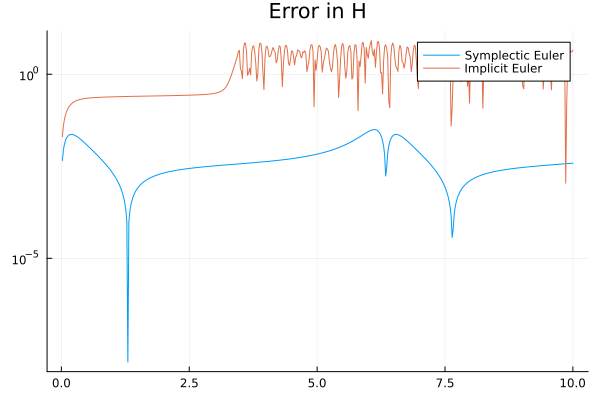

In [17]:
plot(t[2:end],Invariants_error_sE[1,:],yaxis=:log,title="Error in H",label="Symplectic Euler")
# plot!(t[2:end],Invariants_error_SV[1,:],yaxis=:log,label="Störmer-Verlet")
plot!(t[2:end],Invariants_error_IE[1,:],yaxis=:log,label="Implicit Euler")
# plot!(t[2:end],Invariants_error_IM[1,:],yaxis=:log,label="Implicit Midpoint")

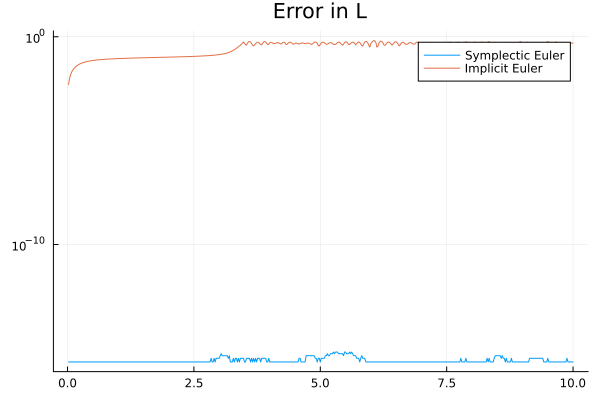

In [18]:
plot(t[2:end],Invariants_error_sE[2,:],yaxis=:log,title="Error in L",label="Symplectic Euler")
# plot!(t[2:end],Invariants_error_SV[2,:],yaxis=:log,label="Störmer-Verlet")
plot!(t[2:end],Invariants_error_IE[2,:],yaxis=:log,label="Implicit Euler")
# plot!(t[2:end],Invariants_error_IM[2,:],yaxis=:log,label="Implicit Midpoint")

例えば，T=100あたりまで計算したとき，どのような振る舞いになるでしょうか？